/var/folders/xd/6b7x17ts5b7612cqwyl3b63m0000gp/T/ipykernel_34628/478398156.py:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.sqrt(np.trapz((ue - uh_interp)**2, xx))


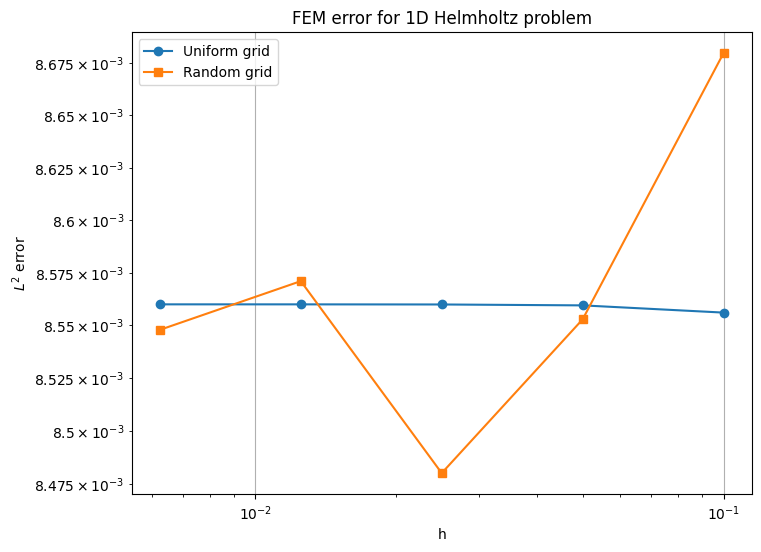

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

def u_exact(x, omega):
    A = np.array([
        [1.0, 1.0],
        [np.exp(omega), np.exp(-omega)]
    ])
    b = np.array([
        -2.0 / omega**4,
        -1.0 / omega**2 - 2.0 / omega**4
    ])
    C1, C2 = solve(A, b)

    return (
        C1 * np.exp(omega * x)
        + C2 * np.exp(-omega * x)
        + x**2 / omega**2
        + 2.0 / omega**4
    )

def fem_helmholtz_1d(x, omega):
    N = len(x) - 1
    h = np.diff(x)

    K = np.zeros((N-1, N-1))
    F = np.zeros(N-1)

    for i in range(N):
        hi = h[i]

        Ke = np.array([
            [1/hi + omega**2 * hi / 3, -1/hi + omega**2 * hi / 6],
            [-1/hi + omega**2 * hi / 6, 1/hi + omega**2 * hi / 3]
        ])

        xL, xR = x[i], x[i+1]
        Fe = np.array([
            (xR**4 - xL**4)/12 - xL*(xR**3 - xL**3)/6,
            xR*(xR**3 - xL**3)/6 - (xR**4 - xL**4)/12
        ])

        for a in range(2):
            I = i + a - 1
            if 0 <= I < N-1:
                F[I] += Fe[a]
                for b in range(2):
                    J = i + b - 1
                    if 0 <= J < N-1:
                        K[I, J] += Ke[a, b]

    u_inner = solve(K, F)
    u = np.zeros(N+1)
    u[1:-1] = u_inner
    return u


def l2_error(x, uh, omega):
    xx = np.linspace(0, 1, 4000)
    uh_interp = np.interp(xx, x, uh)
    ue = u_exact(xx, omega)
    return np.sqrt(np.trapz((ue - uh_interp)**2, xx))


omega = 5.0
Ns = [10, 20, 40, 80, 160]
hs = []
err_uniform = []
err_random = []

for N in Ns:
    x = np.linspace(0, 1, N+1)
    uh = fem_helmholtz_1d(x, omega)
    err = l2_error(x, uh, omega)

    hs.append(1/N)
    err_uniform.append(err)

for N in Ns:
    x = np.sort(np.random.rand(N-1))
    x = np.concatenate(([0.0], x, [1.0]))
    uh = fem_helmholtz_1d(x, omega)
    err = l2_error(x, uh, omega)
    err_random.append(err)

plt.figure(figsize=(8,6))
plt.loglog(hs, err_uniform, 'o-', label="Uniform grid")
plt.loglog(hs, err_random, 's-', label="Random grid")
#plt.loglog(hs, np.array(hs)**2, '--', label=r"$h^2$")
plt.xlabel("h")
plt.ylabel(r"$L^2$ error")
plt.legend()
plt.grid(True)
plt.title("FEM error for 1D Helmholtz problem")
plt.show()
